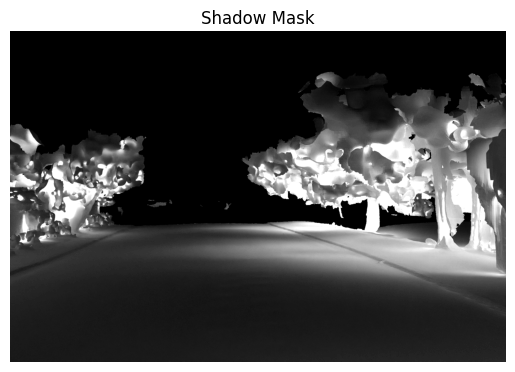

In [38]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Paths to the images
with_shadow_path = 'test/with_shadow.png'
without_shadow_path = 'test/without_shadow.png'

# Open the images
with_shadow_image = Image.open(with_shadow_path)
without_shadow_image = Image.open(without_shadow_path)

# Convert images to numpy arrays
with_shadow_array = np.asarray(with_shadow_image) / 255.0
without_shadow_array = np.asarray(without_shadow_image) / 255.0

# Calculate the difference between the RGB channels
shadow_diff = np.abs(with_shadow_array[..., :3] - without_shadow_array[..., :3])


alpha = 10
# Normalize the difference to create the shadow mask
shadow_mask = np.mean(shadow_diff, axis=-1) * alpha

# Clamp the values to 0 and 1
shadow_mask = (np.clip(shadow_mask, 0, 1) * 255).astype(np.uint8) 


# Display the shadow mask
plt.imshow(shadow_mask, cmap='gray')
plt.title('Shadow Mask')
plt.axis('off')
plt.show()

In [39]:
original_image_path = 'test/000018_0.png'
original_image = Image.open(original_image_path)

Regularization Term 1 : 0.6480277506510417
Regularization Term 2 : [0.5]
Total Loss: [0.01296732], MSE Loss: 0.00012308497345504422, Regularization Loss: [0.01284424], at alpha: [1.]
Regularization Term 1 : 0.6501513671875
Regularization Term 2 : [0.52380952]
Total Loss: [0.01233557], MSE Loss: 0.00014894008515055945, Regularization Loss: [0.01218663], at alpha: [1.1]
Regularization Term 1 : 0.6501513671875
Regularization Term 2 : [0.5015744]
Total Loss: [0.01290922], MSE Loss: 0.00012526351644092615, Regularization Loss: [0.01278396], at alpha: [1.00631748]
Regularization Term 1 : 0.6501513671875
Regularization Term 2 : [0.52523776]
Total Loss: [0.01229948], MSE Loss: 0.0001507852349342356, Regularization Loss: [0.0121487], at alpha: [1.10631748]
Regularization Term 1 : 0.6501513671875
Regularization Term 2 : [0.54156848]
Total Loss: [0.01189138], MSE Loss: 0.00017278202801565562, Regularization Loss: [0.0117186], at alpha: [1.18135089]
Regularization Term 1 : 0.6501513671875
Regulari

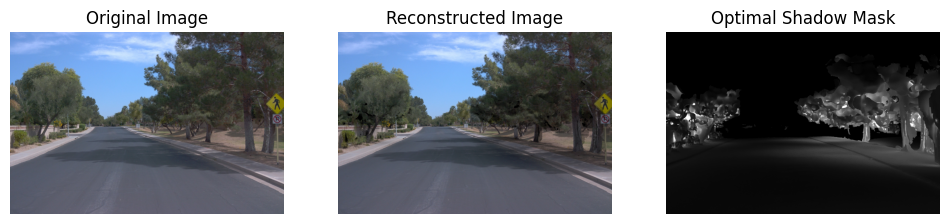

In [58]:
import numpy as np
from PIL import Image
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def clamp_the_image(alpha, with_shadow_array, without_shadow_array):
    shadow_diff = np.abs(with_shadow_array[..., :3] - without_shadow_array[..., :3])
    shadow_mask = np.mean(shadow_diff, axis=-1) * alpha
    shadow_mask = (np.clip(shadow_mask, 0, 1) * 255).astype(np.uint8) 
    return shadow_mask

alpha_init = [1]

def MSE_loss(alpha, original_image, with_shadow_array, without_shadow_array):
    shadow_mask = clamp_the_image(alpha, with_shadow_array, without_shadow_array)
    shadow_mask = np.stack([shadow_mask] * 3, axis=-1)
    shadow_mask = shadow_mask / 255.0
    black_shadow = np.zeros_like(shadow_mask)
    recon_image = original_image * (1 - shadow_mask) + black_shadow * shadow_mask
    loss = np.mean((recon_image - original_image) ** 2)
    return loss

def regularized_loss(alpha, with_shadow_array, without_shadow_array):
    shadow_mask = clamp_the_image(alpha, with_shadow_array, without_shadow_array)
    num_pixels = np.prod(shadow_mask.shape)
    num_nonzero = np.count_nonzero(shadow_mask)
    nonzero_fraction = num_nonzero / num_pixels
    regularization_term = 1 / (nonzero_fraction + 10 * alpha/ (alpha + 10))
    print(f"Regularization Term 1 : {nonzero_fraction}")
    print(f"Regularization Term 2 : {alpha/ (alpha + 1)}")
    loss = regularization_term
    return loss

original_image_path = 'test/000018_0.png'
original_image = Image.open(original_image_path)
with_shadow_path = 'test/with_shadow.png'
without_shadow_path = 'test/without_shadow.png'

with_shadow_image = Image.open(with_shadow_path)
without_shadow_image = Image.open(without_shadow_path)

original_image_array = np.asarray(original_image) / 255.0
with_shadow_array = np.asarray(with_shadow_image) / 255.0
without_shadow_array = np.asarray(without_shadow_image) / 255.0

# weights = [1.0, 0.001, 0.01]
weights = [1.0, 0.02]


def loss(alpha, original_image, with_shadow_array, without_shadow_array, weights):
    mse_loss = MSE_loss(alpha, original_image, with_shadow_array, without_shadow_array)
    reg_loss = regularized_loss(alpha, with_shadow_array, without_shadow_array)
    total_loss = weights[0] * mse_loss + weights[1] * reg_loss
    print(f"Total Loss: {total_loss}, MSE Loss: {weights[0] * mse_loss}, Regularization Loss: {weights[1] * reg_loss}, at alpha: {alpha}")
    return total_loss

def objective(alpha):
    return loss(alpha, original_image_array, with_shadow_array, without_shadow_array, weights)

result = minimize(objective, alpha_init, method='L-BFGS-B', bounds=[(1e-8, None)], tol=1e-6, options={'maxiter': 100, 'eps': 1e-1})

optimal_alpha = result.x[0]
print(f"Optimal alpha: {optimal_alpha}")
print(f"Loss at optimal alpha: {result.fun}")

def reconstruct_image(alpha, original_image_array, with_shadow_array, without_shadow_array):
    shadow_mask = clamp_the_image(alpha, with_shadow_array, without_shadow_array)
    shadow_mask = np.stack([shadow_mask] * 3, axis=-1)
    shadow_mask = shadow_mask / 255.0
    black_shadow = np.zeros_like(shadow_mask)
    recon_image = original_image_array * (1 - shadow_mask) + black_shadow * shadow_mask
    return recon_image, shadow_mask

recon_image, shadow_mask = reconstruct_image(optimal_alpha, original_image_array, with_shadow_array, without_shadow_array)

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(original_image_array)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(recon_image)
plt.title('Reconstructed Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(shadow_mask[..., 0], cmap='gray')
plt.title('Optimal Shadow Mask')
plt.axis('off')

plt.show()

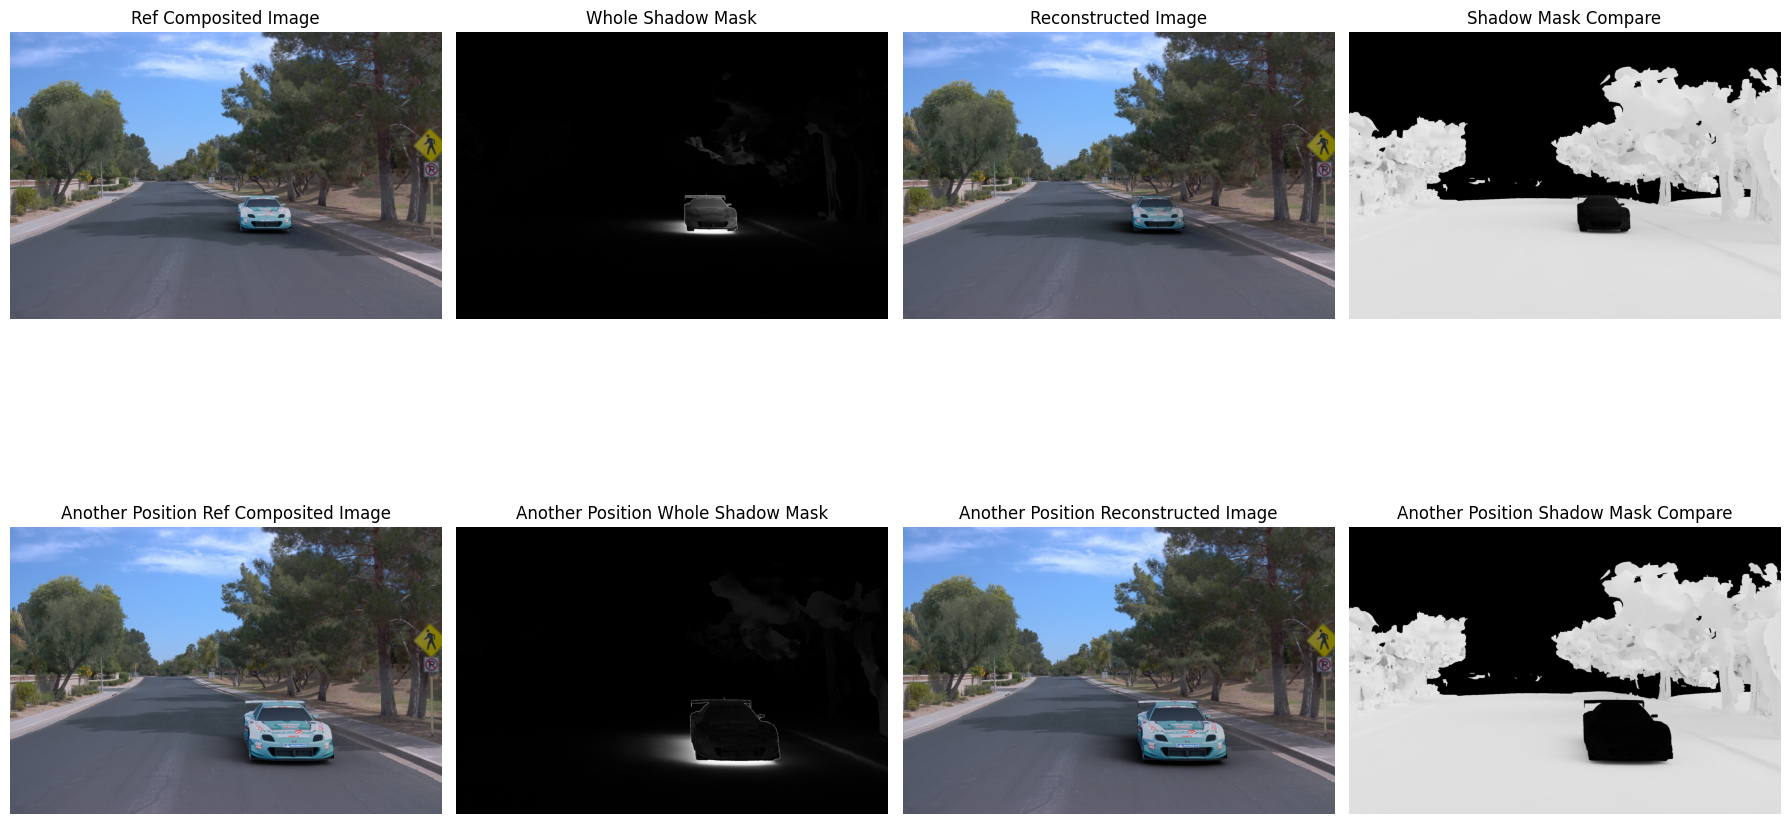

FileNotFoundError: [Errno 2] No such file or directory: '/home/joey/code/bpy_renderer/results/rendered_image_shadow_catcher_1.png'

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load images
original_image_path = 'test/000018_0.png'
original_image = Image.open(original_image_path).convert("RGBA")

fg_image_path = 'test/car_with_shadow_catcher.png'
# fg_image_path = 'results/rendered_image_shadow_catcher_25.png'
fg_image = Image.open(fg_image_path).convert("RGBA")

# Composite the images
ref_composited_image = Image.alpha_composite(original_image, fg_image)

fg_image_with_shadow_path = 'test/car_with_shadow.png'
# fg_image_with_shadow_path = 'results/rendered_image_car_with_shadow_25.png'
fg_image_with_shadow = Image.open(fg_image_with_shadow_path).convert("RGBA")
fg_image_with_shadow_array = np.asarray(fg_image_with_shadow) / 255.0


# Function to clamp the image
def clamp_the_image(alpha, with_shadow_array, without_shadow_array):
    shadow_diff = np.abs(with_shadow_array[..., :3] - without_shadow_array[..., :3])
    shadow_mask = np.mean(shadow_diff, axis=-1) * alpha
    shadow_mask = (np.clip(shadow_mask, 0, 1) * 255).astype(np.uint8) 
    return shadow_mask

# Function to calculate shadow mask and reconstruct image
def calculate_shadow_and_reconstruct(original_image, fg_image, fg_image_with_shadow_array, alpha=3.69):
    fg_image_with_shadow_catcher_array = np.asarray(fg_image) / 255.0
    fg_image_mask = fg_image_with_shadow_catcher_array[..., 3] == 1
    shadow_mask_compare = clamp_the_image(1.0, fg_image_with_shadow_catcher_array, fg_image_with_shadow_array)
    shadow_mask_compare = np.stack([shadow_mask_compare] * 3, axis=-1)

    whole_shadow_mask = shadow_mask_compare[..., 0]
    whole_shadow_mask = whole_shadow_mask * fg_image_mask
    bg_mask = 1 - fg_image_mask
    whole_shadow_mask = whole_shadow_mask / 255.0 + fg_image_with_shadow_catcher_array[..., 3] * bg_mask
    whole_shadow_mask = np.stack([whole_shadow_mask] * 3, axis=-1)

    black_shadow = np.zeros_like(whole_shadow_mask)
    clamped_shadow_mask = np.stack([clamp_the_image(alpha, whole_shadow_mask, black_shadow) / 255.0] * 3, axis=-1) * fg_image_mask[..., None] + fg_image_with_shadow_catcher_array[..., 3][..., None] * bg_mask[..., None]

    ref_image_rgb = np.asarray(original_image)[..., :3] / 255.0
    new_image = ref_image_rgb * (1 - clamped_shadow_mask) + black_shadow * clamped_shadow_mask 

    return shadow_mask_compare, clamped_shadow_mask, new_image

# Calculate shadow mask and reconstruct image for the first position
shadow_mask_compare, clamped_shadow_mask, new_image = calculate_shadow_and_reconstruct(
    ref_composited_image, fg_image, fg_image_with_shadow_array
)

# Load images for another position
another_position_car_shadow_catcher_image_path = 'test/car_with_new_shadow_catcher.png'
another_position_car_shadow_catcher_image = Image.open(another_position_car_shadow_catcher_image_path).convert("RGBA")
another_position_car_with_shadow_image_path = 'test/car_with_new_shadow.png'
another_position_car_with_shadow_image = Image.open(another_position_car_with_shadow_image_path).convert("RGBA")
another_position_car_with_shadow_array = np.asarray(another_position_car_with_shadow_image) / 255.0

# Composite the images for another position
another_position_ref_composited_image = Image.alpha_composite(original_image, another_position_car_shadow_catcher_image)

# Calculate shadow mask and reconstruct image for another position
another_position_shadow_mask_compare, another_position_clamped_shadow_mask, another_position_new_image = calculate_shadow_and_reconstruct(
    another_position_ref_composited_image, another_position_car_shadow_catcher_image, another_position_car_with_shadow_array
)

# Create a figure with six subplots in a 2x3 grid
fig, axs = plt.subplots(2, 4, figsize=(18, 12))

# Display the original image
axs[0, 0].imshow(ref_composited_image)
axs[0, 0].set_title('Ref Composited Image')
axs[0, 0].axis('off')


# Display the whole shadow mask
axs[0, 1].imshow(clamped_shadow_mask, cmap='gray')
axs[0, 1].set_title('Whole Shadow Mask')
axs[0, 1].axis('off')

# Display the reconstructed image
axs[0, 2].imshow(new_image)
axs[0, 2].set_title('Reconstructed Image')
axs[0, 2].axis('off')

# Display the shadow mask compare
axs[0, 3].imshow(shadow_mask_compare[..., 0], cmap='gray')
axs[0, 3].set_title('Shadow Mask Compare')
axs[0, 3].axis('off')

# Display the reference image for another position
axs[1, 0].imshow(another_position_ref_composited_image)
axs[1, 0].set_title('Another Position Ref Composited Image')
axs[1, 0].axis('off')

# Display the reconstructed image for another position
axs[1, 2].imshow(another_position_new_image)
axs[1, 2].set_title('Another Position Reconstructed Image')
axs[1, 2].axis('off')

# Display the whole shadow mask for another position
axs[1, 1].imshow(another_position_clamped_shadow_mask, cmap='gray')
axs[1, 1].set_title('Another Position Whole Shadow Mask')
axs[1, 1].axis('off')

# Display the shadow mask compare for another position
axs[1, 3].imshow(another_position_shadow_mask_compare[..., 0], cmap='gray')
axs[1, 3].set_title('Another Position Shadow Mask Compare')
axs[1, 3].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

# the input directory is results/rendered_image_shadow_catcher_{i}.png and results/rendered_image_car_with_shadow_{i}.png, i varies from 1 to 40, read them and generate the image like another_position_new_image and save the results in the output directory as results/composite_image_{i}.png

# Paths
original_image_path = 'test/000018_0.png'
input_shadow_catcher_template = 'results/rendered_image_shadow_catcher_{}.png'
input_car_with_shadow_template = 'results/rendered_image_car_with_shadow_{}.png'
output_composite_template = 'results/composite_image_{}.png'
output_composite_side_by_side_template = 'results/composite_side_by_side_{}.png'

# Load the original image
original_image = Image.open(original_image_path).convert("RGBA")

# Loop through the images and generate the composite images
for i in range(1, 41):
    shadow_catcher_path = input_shadow_catcher_template.format(i)
    car_with_shadow_path = input_car_with_shadow_template.format(i)
    output_path = output_composite_template.format(i)

    # Load the foreground images
    fg_image = Image.open(shadow_catcher_path).convert("RGBA")
    fg_image_with_shadow = Image.open(car_with_shadow_path).convert("RGBA")
    # composite original_image and fg_image
    ref_composited_image = Image.alpha_composite(original_image, fg_image)
    fg_image_with_shadow_array = np.asarray(fg_image_with_shadow) / 255.0

    # Calculate shadow mask and reconstruct image
    _, whole_shadow_mask, new_image = calculate_shadow_and_reconstruct(ref_composited_image, fg_image, fg_image_with_shadow_array)

    # Save the composite image
    new_image = (new_image * 255).astype(np.uint8)
    new_image_pil = Image.fromarray(new_image)
    new_image_pil.save(output_path)

    # save the whole shadow mask
    whole_shadow_mask = (whole_shadow_mask * 255).astype(np.uint8)
    whole_shadow_mask_pil = Image.fromarray(whole_shadow_mask)
    whole_shadow_mask_pil.save(f"results/whole_shadow_mask_{i}.png")

    print(f"Composite image {i} saved successfully.")
    harmonization_mask = (whole_shadow_mask[..., 0] > 0).astype(np.uint8) * 255
    harmonization_mask_pil = Image.fromarray(harmonization_mask)
    harmonization_mask_pil.save(f"results/harmonization_mask_{i}.png")

    # concate new_image_pil, fg_image_with_shadow, whole_shadow_mask side by side and save the image
    new_image_pil = new_image_pil.convert("RGBA")
    fg_image_with_shadow = fg_image_with_shadow.convert("RGBA")
    whole_shadow_mask_pil = whole_shadow_mask_pil.convert("RGBA")

    # Create a new image with width = sum of widths and height = max of heights
    width = new_image_pil.width + fg_image_with_shadow.width + whole_shadow_mask_pil.width
    height = max(new_image_pil.height, fg_image_with_shadow.height, whole_shadow_mask_pil.height)
    concatenated_image = Image.new('RGBA', (width, height))

    # Paste images side by side
    concatenated_image.paste(new_image_pil, (0, 0))
    concatenated_image.paste(fg_image_with_shadow, (new_image_pil.width, 0))
    concatenated_image.paste(whole_shadow_mask_pil, (new_image_pil.width + fg_image_with_shadow.width, 0))

    # Save the concatenated image
    concatenated_image.save(output_composite_side_by_side_template.format(i))

    print(f"Concatenated side-by-side image {i} saved successfully.")




In [4]:
# convert the side by side images to mp4
import imageio
output_video_path = 'results/composite_video.mp4'
# Create a video from the concatenated images
with imageio.get_writer(output_video_path, fps=24, codec='libx264') as writer:
    for i in range(1, 41):
        output_composite_path = output_composite_side_by_side_template.format(i)
        image = imageio.imread(output_composite_path)
        writer.append_data(image)

print(f"Composite video saved successfully at {output_video_path}.")

/tmp/ipykernel_189125/436510560.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(output_composite_path)


Composite video saved successfully at results/composite_video.mp4.
